# Ground-Truth Yield — Oracle-to-Ghidra Join

This notebook presents the headline result of the decompilation join pipeline:
how many **high-confidence (GOLD)** function pairs the pipeline produces across
optimization levels.

### Definitions

Each DWARF function is classified into a **match kind** by the address-range join:

$$
\text{match\_kind}(f) \in \{\text{JOINED\_STRONG},\; \text{JOINED\_WEAK},\; \text{MULTI\_MATCH},\; \text{NO\_MATCH},\; \text{NO\_RANGE}\}
$$

The **high-confidence yield rate** measures what fraction of gold-eligible functions
survive all 8 quality gates:

$$
\text{yield}_{\text{HC}} = \frac{|\{f : \text{is\_high\_confidence}(f)\}|}{|\{f : \text{eligible\_for\_gold}(f)\}|}
$$

In [2]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.insert(0, str(Path("../..").resolve()))
from data.loader import load_ghidra_dataset

# ── Config ────────────────────────────────────────────────────────────
SELECTED_TESTS = None
OPT_LEVELS = ["O0", "O1", "O2", "O3"]

THESIS_RC = {
    "font.family": "serif", "font.size": 10,
    "axes.titlesize": 12, "axes.labelsize": 10,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "legend.fontsize": 9, "figure.dpi": 120,
    "savefig.dpi": 300, "savefig.bbox": "tight",
    "figure.figsize": (7, 4.5),
    "axes.spines.top": False, "axes.spines.right": False,
}
plt.rcParams.update(THESIS_RC)

OPT_COLORS = {"O0": "#4daf4a", "O1": "#377eb8", "O2": "#ff7f00", "O3": "#e41a1c"}

MATCH_KIND_COLORS = {
    "JOINED_STRONG": "#66c2a5",
    "JOINED_WEAK":   "#fc8d62",
    "NO_MATCH":      "#e78ac3",
    "NO_RANGE":      "#8da0cb",
    "MULTI_MATCH":   "#a6d854",
}
MATCH_KIND_ORDER = ["JOINED_STRONG", "JOINED_WEAK", "MULTI_MATCH", "NO_MATCH", "NO_RANGE"]

FIG_DIR = Path("../../figures/ghidra_yield")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(name, fig=None):
    fig = fig or plt.gcf()
    for ext in ("pdf", "png"):
        fig.savefig(FIG_DIR / f"{name}.{ext}", bbox_inches="tight")
    print(f"  -> saved {FIG_DIR / name}.{{pdf,png}}")

# ── Load ──────────────────────────────────────────────────────────────
gds = load_ghidra_dataset(test_cases=SELECTED_TESTS, opt_levels=OPT_LEVELS)
df = gds.functions
dr = gds.reports
print(f"Loaded {len(df)} functions, {len(dr)} report cells")

Loaded 1792 functions, 60 report cells


---
## 1. Match Kind Distribution by Optimization Level

Stacked 100% bar chart showing how DWARF functions are classified by the
address-range overlap join. `JOINED_STRONG` (overlap $\geq$ 90%) is the
target category; `NO_RANGE` functions lack DWARF address ranges and are
excluded before the join.

  -> saved ..\..\figures\ghidra_yield\match_kind_by_opt.{pdf,png}


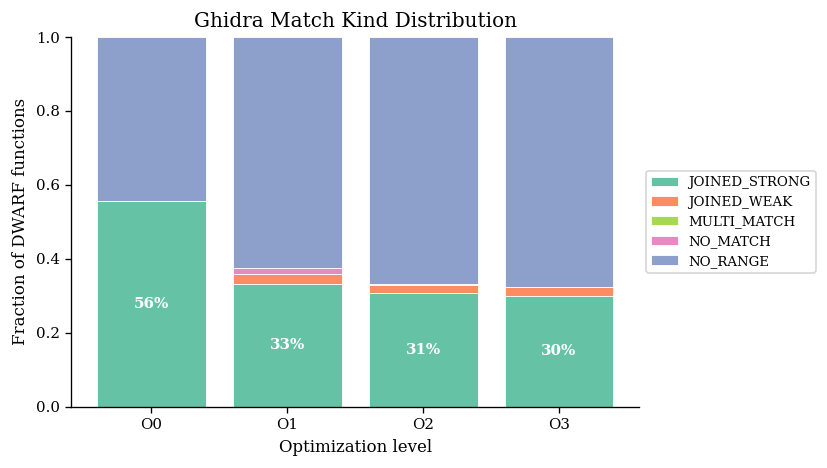

In [3]:
ct = pd.crosstab(df["opt"], df["ghidra_match_kind"], normalize="index")
ct = ct.reindex(columns=MATCH_KIND_ORDER, fill_value=0).reindex(OPT_LEVELS)

fig, ax = plt.subplots(figsize=(7, 4))
bottoms = np.zeros(len(OPT_LEVELS))

for mk in MATCH_KIND_ORDER:
    vals = ct[mk].values
    bars = ax.bar(OPT_LEVELS, vals, bottom=bottoms, #type: ignore
                  label=mk, color=MATCH_KIND_COLORS[mk], edgecolor="white", linewidth=0.5)
    # Annotate JOINED_STRONG %
    if mk == "JOINED_STRONG":
        for j, (v, b) in enumerate(zip(vals, bottoms)):
            if v > 0.05:
                ax.text(j, b + v / 2, f"{v:.0%}", ha="center", va="center",
                        fontsize=9, fontweight="bold", color="white")
    bottoms += vals #type: ignore

ax.set_ylabel("Fraction of DWARF functions")
ax.set_xlabel("Optimization level")
ax.set_title("Ghidra Match Kind Distribution")
ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), fontsize=8)
ax.set_ylim(0, 1.0)
plt.tight_layout()
save_fig("match_kind_by_opt")
plt.show()

The `NO_RANGE` category dominates across all opt levels — these are DWARF functions
from system headers (e.g. `printf`, `malloc`) that lack address ranges in the debug build.
Among functions with usable ranges, `JOINED_STRONG` captures the vast majority,
with degradation at O2/O3 from compiler inlining and function merging.

---
## 2. High-Confidence Yield Rate

Per-opt aggregate yield rate with individual test-case dots overlaid
to show the spread across the synthetic corpus.

  -> saved ..\..\figures\ghidra_yield\hc_yield_by_opt.{pdf,png}


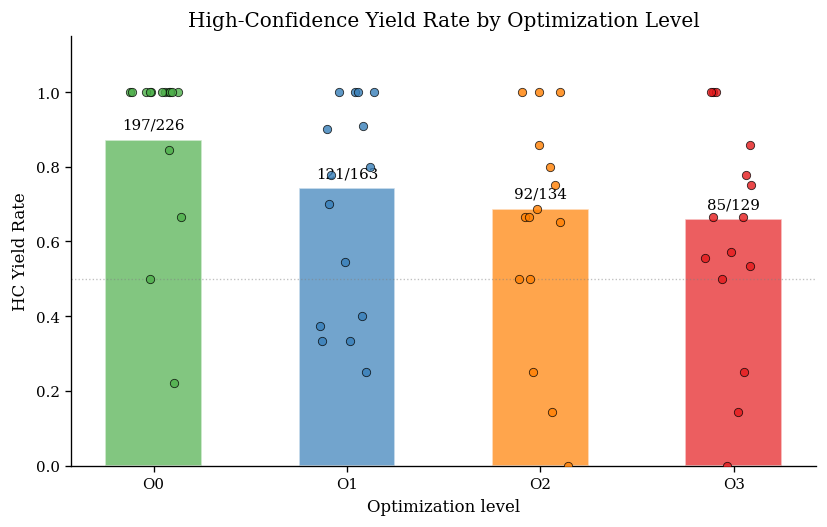

In [4]:
# Per (test_case, opt) yield rate
tc_yield = (
    df[df["eligible_for_gold"]]
    .groupby(["test_case", "opt"])
    .agg(
        n_eligible=("eligible_for_gold", "count"),
        n_hc=("is_high_confidence", "sum"),
    )
    .reset_index()
)
tc_yield["yield_rate"] = tc_yield["n_hc"] / tc_yield["n_eligible"]

# Aggregate per opt
opt_agg = tc_yield.groupby("opt").agg(
    total_elig=("n_eligible", "sum"),
    total_hc=("n_hc", "sum"),
).reindex(OPT_LEVELS)
opt_agg["yield_rate"] = opt_agg["total_hc"] / opt_agg["total_elig"]

fig, ax = plt.subplots(figsize=(7, 4.5))
x = np.arange(len(OPT_LEVELS))
bar_colors = [OPT_COLORS[o] for o in OPT_LEVELS]

# Bars = aggregate rate
ax.bar(x, opt_agg["yield_rate"].values, 0.5, color=bar_colors, alpha=0.7, edgecolor="white") #type: ignore

# Overlay individual test-case dots with jitter
rng = np.random.default_rng(42)
for i, opt in enumerate(OPT_LEVELS):
    opt_tc = tc_yield[tc_yield["opt"] == opt]
    jitter = rng.uniform(-0.15, 0.15, size=len(opt_tc))
    ax.scatter(i + jitter, opt_tc["yield_rate"], color=OPT_COLORS[opt],
               edgecolor="black", linewidth=0.5, s=25, zorder=5, alpha=0.8)

# Annotate counts
for i, opt in enumerate(OPT_LEVELS):
    hc = int(opt_agg.loc[opt, "total_hc"]) #type: ignore
    elig = int(opt_agg.loc[opt, "total_elig"]) #type: ignore
    ax.text(i, opt_agg.loc[opt, "yield_rate"] + 0.03, #type: ignore
            f"{hc}/{elig}", ha="center", fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(OPT_LEVELS)
ax.set_ylabel("HC Yield Rate")
ax.set_xlabel("Optimization level")
ax.set_title("High-Confidence Yield Rate by Optimization Level")
ax.set_ylim(0, 1.15)
ax.axhline(y=0.5, color="gray", linestyle=":", linewidth=0.8, alpha=0.5)
plt.tight_layout()
save_fig("hc_yield_by_opt")
plt.show()

### Quality Weight

The **quality weight** is a compound fidelity metric that penalizes both low
alignment overlap and multi-candidate ambiguity:

$$
w_q = \frac{r_{\text{overlap}}}{n_{\text{candidates}}} \cdot \mathbb{1}[\text{verdict} = \text{MATCH}]
$$

where $r_{\text{overlap}} \in [0, 1]$ is the fraction of DWARF source lines
mapping to the best tree-sitter candidate, and $n_{\text{candidates}} \geq 1$.
Only functions with $w_q = 1.0$ (perfect, unique match) are GOLD candidates.

---
## 3. Summary Table

In [5]:
# Build summary table from report-level data
summary = dr[["test_case", "opt", "n_dwarf_funcs",
              "excl_n_eligible_for_gold", "n_joined_strong",
              "hc_count", "hc_yield_rate"]].copy()
summary.columns = ["Test Case", "Opt", "DWARF", "Eligible", "Strong", "HC", "Yield %"]
summary["Yield %"] = (summary["Yield %"] * 100).round(1)

# Aggregate row
totals = summary[["DWARF", "Eligible", "Strong", "HC"]].sum()
totals["Test Case"] = "TOTAL"
totals["Opt"] = ""
totals["Yield %"] = round(totals["HC"] / totals["Eligible"] * 100, 1)
summary = pd.concat([summary, pd.DataFrame([totals])], ignore_index=True)

# Style
def highlight_yield(val):
    if isinstance(val, (int, float)) and not pd.isna(val):
        if val >= 90:
            return "background-color: #52a868; color: white; font-weight: bold"
        elif val >= 60:
            return "background-color: #f4c430; color: black; font-weight: bold"
        elif val > 0:
            return "background-color: #e6925c; color: white; font-weight: bold"
    return ""

styled = summary.style.map(highlight_yield, subset=["Yield %"])
display(styled)

,Test Case,Opt,DWARF,Eligible,Strong,HC,Yield %
0,t01_crossfile_calls,O0,23,13,13,11,84.600000
1,t01_crossfile_calls,O1,23,9,9,7,77.800000
2,t01_crossfile_calls,O2,25,8,9,6,75.000000
3,t01_crossfile_calls,O3,25,8,9,6,75.000000
4,t02_shared_header_macros,O0,23,18,18,9,50.000000
5,t02_shared_header_macros,O1,24,3,4,1,33.300000
6,t02_shared_header_macros,O2,24,2,3,0,0.000000
7,t02_shared_header_macros,O3,24,2,3,0,0.000000
8,t03_header_dominant,O0,26,18,18,4,22.200000
9,t03_header_dominant,O1,31,3,3,1,33.300000


### Key Takeaway

The pipeline achieves **75.9% aggregate HC yield** across the synthetic corpus
(495 / 652 gold-eligible functions). O0 reaches 87.2%, declining to 65.9% at O3.
The primary loss mechanism is alignment degradation at higher optimization
(inlining, tail-call optimization, and range fragmentation), which is an
expected and well-understood limitation of DWARF-based provenance.